# Modeling

Now that we have explored our data, and cleaned it up into an acceptable format, we are ready to run some modeling techniques on it. We will begin by building multiple generic models on the data set to see how well it performs. After this, we will build a Neural Network to see if we can improve the performance from the baseline models.

In [11]:
#Import Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

### Loading Dataset

This dataset is already cleaned up and preprocessed. It is expected that this dataset has the following columns:
* SALEPRICE
* PROPERTYZIP

> NOTE/TODO: Currently, we don't do anything with the PROPERTYZIP. We plan to build a model for each zipcode, but that is pending our preliminary results (to see if we need to even attempt such a thing).

In [12]:
# Loading Data
data = pd.read_csv('output_total_df.csv')

# Renaming columns to not include brackets, spaces, or commas
column_mapping = {}
for col in list(data.columns):

    new_col = col.replace(']', ')')
    new_col = new_col.replace('[', '(')
    new_col = new_col.replace(', ', '-')
    new_col = new_col.replace(' ', '')
    column_mapping[col] = new_col

data = data.rename(columns=column_mapping)

# Drop Nulls
data = data.dropna()

In [13]:
data.head()

,Unnamed:0,STYLE,ROOF,EXTFINISH,BASEMENT,STORIES,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS,FINISHEDLIVINGAREA,ZIPCODE,YEARSOLD,Condition,GRADE,CDU,LOTAREA,COUNTYTOTAL,COUNTYBUILDING,COUNTYLAND,SALEPRICE
0,2,24.0,2.0,6.0,5.0,-1.264172,-2.140282,-1.237946,0.782665,-0.947308,-0.245785,95.0,-1.942389,0.012626,-4.275111,4.0,-0.295716,1.875418,2.771835,-1.2102,525000.0
1,11,24.0,2.0,6.0,5.0,-1.264172,-2.140282,-2.394149,-0.763327,0.796003,-0.529069,95.0,-1.942389,0.012626,-4.275111,4.0,-0.295716,1.661966,2.505806,-1.2102,394000.0
2,70,24.0,2.0,6.0,5.0,-1.264172,-0.934785,-0.081743,0.782665,-0.947308,0.402313,95.0,-1.942389,0.012626,-4.275111,4.0,-0.295716,3.357076,4.618456,-1.2102,355900.0
3,72,24.0,2.0,6.0,5.0,-1.264172,-1.537534,-1.237946,-0.763327,0.796003,-0.364626,95.0,-1.942389,0.012626,-4.275111,4.0,-0.295716,1.775422,2.647209,-1.2102,333325.0
4,74,24.0,2.0,6.0,5.0,-1.264172,-1.537534,-1.237946,0.782665,-0.947308,-0.342516,95.0,-1.942389,0.012626,-4.275111,4.0,-0.295716,2.296551,3.296702,-1.2102,382000.0


## Train/Validation/Test Split

We will split our dataset into three sets:
* Training - (77%)
* Validation - (16.5%)
* Testing - (16.5%)

In [14]:
from sklearn.model_selection import train_test_split

X = data.drop(['Unnamed:0', 'SALEPRICE'], axis=1)
Y = data['SALEPRICE']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

print("Training Shape: ", X_train.shape)
print("Validation Shape: ", X_val.shape)
print("Testing Shape: ", X_test.shape)

Training Shape:  (96248, 19)
Validation Shape:  (23703, 19)
Testing Shape:  (23704, 19)


In [15]:
X_train.head(1)

,STYLE,ROOF,EXTFINISH,BASEMENT,STORIES,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS,FINISHEDLIVINGAREA,ZIPCODE,YEARSOLD,Condition,GRADE,CDU,LOTAREA,COUNTYTOTAL,COUNTYBUILDING,COUNTYLAND
12663,24.0,2.0,6.0,5.0,-1.264172,-1.537534,-1.237946,-0.763327,-0.947308,-1.112219,95.0,2.115945,1.797994,2.118914,5.0,-0.102745,-0.852333,-0.944175,-0.328983


# Modeling
We will build some models on our data and see which model performs the best. The following models will be evaluated:

* XGBoost
* RandomForest
* KNearest Neighbors
* Support Vector Machine
* Gradient Boosted Decision Tree

## Testing Function
Here we will define a function that accepts a model, parameters, and data. This model will build the model and test it.

This function will be useful for testing all of our models.

In [16]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time

def test_model(model, params, model_name, X_train, y_train, X_test, Y_test):
    """Trains model, and evaluates it.
        PARAMS:
            model_choice - SKLearn Model: Model to be trained
            params - dictionary: Dictionary of parameters to feed the model
            X_train - DataFrame: Training Data, Features
            y_train - DataFrame: Training Data, Targets
            X_test - DataFrame: Testing Data, Features
            y_test - DataFrame: Testing Data, Targets
        
        RETURNS:
            Mean Squared Log Error, Tree Explainer, Model Name - tuple(float, Explainer, String): Accuracy for specified model and parameters. 
    """
    print("Begin ", model_name)
    start = time.time()

    # Run model and get predictions and Mean Squared Log Error
    clf = model(**params)
    clf.fit(X_train, y_train)
    
    predictions = clf.predict(X_test)
    if predictions.min() < 10000:
        print("\t- [WARNING] - Out of bounds prediction... Replacing with 10,000")
        predictions[predictions < 0] = 10000
    
    msle = mean_squared_log_error(Y_test, predictions)
    rmse = mean_squared_error(Y_test, predictions)**0.5
    r2 = r2_score(Y_test, predictions)
    
    print(f"\t- MSLE: ", msle)
    print(f"\t- RMSE: ", rmse)
    print(f"\t- R^2: ", r2)
    
    print("\t- Time Elapsed: ", time.time() - start)
    
    return (msle, clf, model_name)

## Testing Models
We will run all of the following models through the testing function:
* XGBoost
* RandomForest
* KNearest Neighbors
* Support Vector Machine
* Gradient Boosted Decision Tree

Each of these models will be trained on the `Training Set` and evaluated on the `Validation Set`. The model that performs the best on the evaluation set (lowest `Mean Squared Log Error`), will be promoted to the next phase of model tuning (Hyper Parameter Tuning).

In [17]:
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

knc_params = {}
svr_params = {}
gbr_params = {}
xgb_params = {'objective':'reg:squarederror'}
rf_params = {}

models_to_test = [
    (xgb.XGBRegressor, xgb_params, "XGBoost"),
    (RandomForestRegressor, rf_params, "Random Forest"),
    (KNeighborsRegressor, knc_params, "KNeighbors"),
    (LinearSVR, svr_params, "Support Vector Machine"),
    (GradientBoostingRegressor, gbr_params, "GradientBoostingRegressor")
]

results = []
for model in models_to_test:
    results += [test_model(model[0], model[1], model[2], X_train, y_train, X_val, y_val)]

Begin  XGBoost
	- [WARNING] - Out of bounds prediction... Replacing with 10,000
	- MSLE:  0.25192550371235434
	- RMSE:  54125.77829782926
	- R^2:  0.7400719225692916
	- Time Elapsed:  4.448635101318359
Begin  Random Forest
	- MSLE:  0.251020810896491
	- RMSE:  54547.013431834246
	- R^2:  0.7360103866620327
	- Time Elapsed:  77.58210611343384
Begin  KNeighbors
	- MSLE:  0.2806998968462539
	- RMSE:  59574.86877651987
	- R^2:  0.6851011499160429
	- Time Elapsed:  23.34947681427002
Begin  Support Vector Machine
	- [WARNING] - Out of bounds prediction... Replacing with 10,000
	- MSLE:  0.28793060415909666
	- RMSE:  63210.41862398516
	- R^2:  0.6454951191322128
	- Time Elapsed:  0.29523372650146484
Begin  GradientBoostingRegressor
	- [WARNING] - Out of bounds prediction... Replacing with 10,000
	- MSLE:  0.2536600811554908
	- RMSE:  54216.017522928625
	- R^2:  0.7392044889041048
	- Time Elapsed:  16.779532194137573


In [18]:
# Sort results by the best accuracy.
results.sort(key = lambda x: x[0], reverse=False)

print("Best Model: ", results[0][2])

Best Model:  Random Forest


## Hyper Parameter Tuning
`Random Forest` has the best performance.

We will now run a Grid Search on it to see which parameters might be most effective. We have already run a Randomized Grid Search (in the past) to see how we should narrow down our parameter space. 

    > NOTE: We are choosing to use a smaller `max_depth`. We do this so it can act as a regularization term. We may not get better results (than a higher max_depth), but we will get a more general model.

In [ ]:
from sklearn.model_selection import GridSearchCV

def grid_search(clf, params, model_name, X_train, y_train, X_test, y_test):
    """Run Grid Search on a model"""
    print("Begin ", model_name)
    
    start = time.time()

    clf = GridSearchCV(clf(), params, refit=False, scoring='neg_mean_squared_log_error', cv=3, n_jobs=-1, verbose=10)
    clf.fit(X_train, y_train)
    
    print("\t- Best Score: ", clf.best_score_)
    print("\t- Time Elapsed: ", time.time() - start)
    
    return (clf.best_score_, clf, model_name)

params_rf = {
    'bootstrap': [True],
    'max_depth': [5, 7, 10], # Making this small to act as regularization.
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [100, 200, 300, 400]
}

models_to_tune = [
    (RandomForestRegressor, params_rf, "RandomForest")
]

tuned_results = []
for model in models_to_tune:
    tuned_results += [grid_search(model[0], model[1], model[2], X_train, y_train, X_val, y_val)]

Begin  RandomForest
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.4min


## Best Parameters
We can view the best parameters by extracting `cv_results_`. This will allow us to see how the best parameters compared to the other parameters.

During the Hyper Parameter Tuning process, this was useful in order to narrow the search space down. For example, We saw consistently worse results during the following:
* bootstrap : False
* max_features : sq_rt

Armed with this knowledge, we were able to reduce the number of parameters we need to search over, so GridSearch might be more efficient

In [ ]:
# Grab parameter results
param_results = pd.DataFrame(tuned_results[0][1].cv_results_).sort_values('rank_test_score')

# Write Parameters to CSV
import os
# if file does not exist write header 
if not os.path.isfile('random_forest_params.csv'):
    param_results.to_csv('random_forest_params.csv', header=True)
else: # else it exists so append without writing the header
    param_results.to_csv('random_forest_params.csv', mode='a', header=False)

param_results.head()

## Evaluate Model

We will evaluate the performance of the `RandomForestRegressor` model on the 
* Training Set
* Validation Set
* Testing Set

Understanding how the results varies within each of the data sets will help us understand how well the model is generalizing to new data. We expect to see a similar results across all data sets.

> NOTE: We will only using the results on the `testing` for determining to accept or decline our model. 

In [ ]:
from sklearn.metrics import mean_squared_log_error

start = time.time()

best_clf = RandomForestRegressor(**tuned_results[0][1].best_params_).fit(X_train, y_train)

print("Time Elapsed: ", time.time() - start)

predictions = best_clf.predict(X_train)
msle = mean_squared_log_error(y_train, predictions)
print("Training Mean Squared Log Error: ", msle)

predictions = best_clf.predict(X_val)
msle = mean_squared_log_error(y_val, predictions)
print("Validation Mean Squared Log Error: ", msle)

predictions = best_clf.predict(X_test)
msle = mean_squared_log_error(y_test, predictions)
print("Testing Mean Squared Log Error: ", msle)

## Zillow's Zestimate
Zillow presents their results via a table that displays the following:
* Median Error
* Homes With ZESTIMATES
* Within 5% of Sale Price
* Within 10% of Sale Price
* Within 20% of Sale Price

We will develop the same metrics from our results and compare them to Zillows results on `Pittsburgh PA`

In [ ]:
y_test = y_test.reset_index(drop=True)

# Concatentate Predictions with Actual
comparison = pd.concat([pd.Series(predictions), y_test], axis=1)
comparison = comparison.rename(columns={0:'PREDICTION'})

# Calculate `Percent Error`
## |(Prediction - SalePrice) / SalePrice|
comparison['PERCENT ERROR'] = abs((comparison['PREDICTION'] - comparison['SALEPRICE']) / comparison['SALEPRICE'])

# Write to CSV
comparison.to_csv('predictions.csv')

In [ ]:
comparison.head()

In [ ]:
# Obtain Metrics to create table.

area = 'Pittsburgh, PA'
median_error = comparison['PERCENT ERROR'].median() * 100
total_estimates = comparison.shape[0]
five_percent = comparison[comparison['PERCENT ERROR'] <= 0.05].shape[0] / comparison.shape[0] * 100
ten_percent = comparison[comparison['PERCENT ERROR'] <= 0.10].shape[0] / comparison.shape[0] * 100
twenty_percent = comparison[comparison['PERCENT ERROR'] <= 0.20].shape[0] / comparison.shape[0] * 100

column_names = ['METROPOLITAN AREA', 'MEDIAN ERROR', 'HOMES WITH ESTIMATE', 'WITH 5% OF SALEPRICE', 'WITH 10% OF SALEPRICE', 'WITH 20% OF SALEPRICE']

results_lst = [area, median_error, total_estimates, five_percent, ten_percent, twenty_percent]
zillow_lst = ['Pittsburgh, PA', 2.5, 10900, 77.6, 93.2, 98.4]

results = pd.DataFrame([results_lst, zillow_lst], index=['Our Results', 'Zillow'], columns=column_names)

results.head()

# Feature Importance:

### Random Forest Feature Importance
Random Forest has a built in feature importance, which will tell us how important each feature is. However, this does not tell us what kind of values the features should have.


### SHAP (SHapley Additive exPlanations)
SHAP measures the impact of variables taking into account the interaction with other variables. 

This will be better than the feature importances found in Random Forest because we can now see how the value of each feature affects the final result.

Reference: 
* https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

* https://blog.datascienceheroes.com/how-to-interpret-shap-values-in-r/Which features are more important to XGBoost?

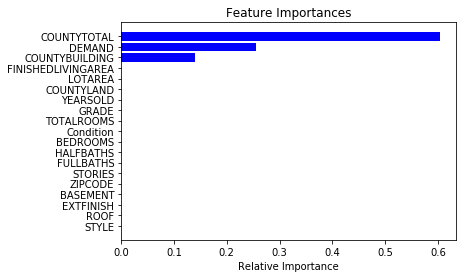

In [9]:
features = X.columns.tolist()
importances = results[0][1].feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [11]:
import shap
print(shap.__version__)

# May need to run the following as system admin in anaconda command prompt
## conda install -c conda-forge shap

0.34.0


In [ ]:
shap_values = shap.TreeExplainer(results[0][1]).shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train) # Change to Red and Green

## Results

We tested the following models:
* XGBoost
* RandomForest
* KNearest Neighbors
* Support Vector Machine
* Gradient Boosted Decision Tree

The best performing model was `RandomForest`. Once we found the best performing model, we implemented a `Grid Search` which aimed to exhaustively explore a specified grid and find the best parameters. Once we tuned our parameters, we tested our predictions on our Training, Validation, and Testing set.

Our testing set had a RMSE of `4780.84`. This indicates that we still have a lot of room for improvements, so we might want to attempt a different approach.